In [1]:
'''
Plot exetent/area from observations and models (past and future)
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
# Plotting Info
runType = 'forecast'
variables = ['sic'] #, 'hi']

In [3]:
# Initialization times to plot
cd = datetime.datetime.now()
cd = datetime.datetime(cd.year, cd.month, cd.day) # Assumes hours 00, min 00
SD = cd - datetime.timedelta(days=35)
ED = cd + datetime.timedelta(days=365)

In [4]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

# Load in Observations
da_51_in = xr.open_mfdataset(E.obs['NSIDC_0051']['sipn_nc']+'/NSIDC_0051.nc')
da_81_in = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/NSIDC_0081.nc')
da_79_in = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'/NSIDC_0079.nc')
ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))
ds_ext = ds_ext.rename({'datetime':'time'})

In [5]:
ds_obs = ds_ext.Extent.combine_first(da_79_in.extent).combine_first(da_51_in.extent).combine_first(da_79_in.extent)

In [6]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask.nc'))
ds_region.set_coords(['lat','lon'], inplace=True);
ds_region.rename({'nx':'x', 'ny':'y'}, inplace=True);

In [7]:
metric1 = 'extent'
cmap_c = itertools.cycle(sns.color_palette("Paired", len(E.model.keys()) ))
linecycler = itertools.cycle(["-","--","-.",":","--"])

ukmetofficesipn
Plotting


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


ecmwfsipn
Plotting


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 2062, in _check_1d
    x[:, None]
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/dataarray.py", line 473, in __getitem__
    return self.isel(**self._item_key_to_dict(key))
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/dataarray.py", line 439, in _item_key_to_dict
    key = indexing.expanded_indexer(key, self.ndim)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/indexing.py", line 42, in expanded_indexer
    raise IndexError('too many indices')
IndexError: too many indices

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_cod

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 2062, in _check_1d
    x[:, None]
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/dataarray.py", line 473, in __getitem__
    return self.isel(**self._item_key_to_dict(key))
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/dataarray.py", line 439, in _item_key_to_dict
    key = indexing.expanded_indexer(key, self.ndim)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/indexing.py", line 42, in expanded_indexer
    raise IndexError('too many indices')
IndexError: too many indices

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_cod

TypeError: must be str, not list

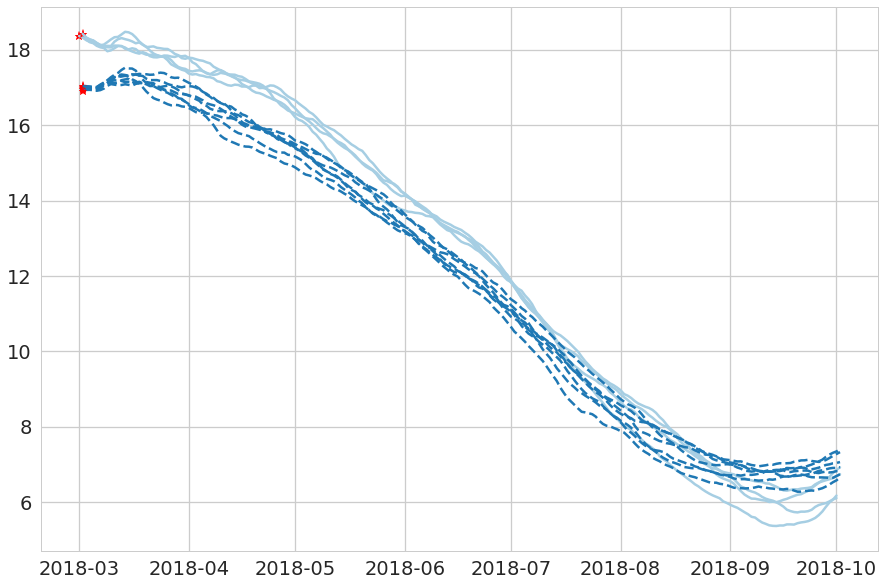

In [8]:
for cvar in variables:
    
    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "timeseries")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # New Plot
    f = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(1, 1, 1) # Observations

    for (i, cmod) in enumerate(E.model.keys()):
        print(cmod)

        # Load in Model
        model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc')

        # Check we have files 
        files = glob.glob(model_forecast)
        if not files:
            #print("Skipping model", cmod, "no forecast files found.")
            continue # Skip this model
        ds_model = xr.open_mfdataset(model_forecast)
        ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

        # Select var of interest (if available)
        if cvar in ds_model.variables:
            ds_model = ds_model[cvar]
        else:
            continue

        # Select init of interest
        ds_model = ds_model.where(ds_model.init_time>=np.datetime64(SD), drop=True)
        # Need check

        # Reduce to extent or area
        if metric1 == 'extent':
            ds_model = ((ds_model >= 0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
        else:
            raise ValueError('Not implemented')
        cc = next(cmap_c) 

        # Plot Model
        print('Plotting')
#         print(ds_model)
        if i == 1: # Control only one initiailzation label in legend
            no_init_label = False
        else:
            no_init_label = True    
        esio.plot_reforecast(ds=ds_model, axin=ax1, 
                             labelin=E.model[cmod]['model_label'],
                             color=cc, marker=None,
                             linestyle=next(linecycler),
                             no_init_label=no_init_label)
             
    # Plot observations
    ds_obs.where(ds_obs.time>=np.datetime64(SD)).plot(ax=ax1, label='Observations (NSIDC)', color='m', linewidth=8)
    ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
    cylims = ax1.get_ylim()
    
    # Plot current date line
    ax1.plot([cd, cd], [cylims[0], cylims[1]], color='k', linestyle='--')
    
    # Add legend (static)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1], labels[::-1], loc='lower right',bbox_to_anchor=(1.35, 0))
    
    f.autofmt_xdate()
    ax1.set_ylim(cylims)
    plt.subplots_adjust(right=.8)
        
    # Save to file
    f_out = os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'.png')
    f.savefig(f_out,bbox_inches='tight',dpi=200)
    mpld3.save_html(f, os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'.html'))
